In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Random Forest Classification

In [ ]:
# Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

In [ ]:
def assign_true_label(row):
  if 'MYS_mgr' in row['label']:
    return 1
  elif 'MYS_hgr' in row['label']:
    return 0
  else:
    return 999




def avg_segment_node_distance(gdf):
    """
    Calculate the average segment length per node for a GeoDataFrame of road segments.

    Parameters:

    - gdf: GeoDataFrame

        GeoDataFrame containing road segment geometries.

    Returns:

    - float

        Average segment length per node.
    """
    # Calculate the length of each road segment
    gdf['segment_length'] = round((gdf['road_length'])/1000,2)

    # Calculate the number of nodes for each road segment
    gdf['num_nodes'] = gdf['n_vertices']
    # Calculate the average segment length per node
    gdf['avg_segment_node_distance'] = gdf['segment_length'] / (gdf['num_nodes'] - 1)

    # Calculate the overall average
    overall_average = gdf['avg_segment_node_distance'].mean()

    return overall_average

In [ ]:
# Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Ref_dataset_Malashyia2.csv")
Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Control_Data_MYS.csv")


# avg_segment_node_distance(Data)
# Data['true_label'] = Data.apply(assign_true_label, axis=1)
# Data['std_node_density'] = Data['node_density'].std()
# Data['std_node_distance'] = Data['avg_segment_node_distance'].std()
# Data['segment_length'] = round((Data['road_length'])/1000,2)

# Reshape X to be a 2D array
X = Data.iloc[:, [-5,  -1]]
y = Data.iloc[:, -8]

print(X.columns)  # Print the columns of the DataFrame X
# use one-hot encoding on the y variable


# Encoding the Dependent Variable (Classification)
le = LabelEncoder()
y = le.fit_transform(y)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(X)  # Fit on the 2D array X
X = imputer.transform(X)    # Transform the data


Index(['std_distance', 'node_density'], dtype='object')


In [ ]:
len(X)

788232

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)


# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False) # Set with_mean=False for sparse matrices
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators =100, criterion = 'entropy', random_state = 0)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predicting the Test set results
y_pred = RF_classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, y_pred, average= 'macro')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall, )

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1 )

# Calculate Sensitivity (same as Recall)
sensitivity = recall
print("Sensitivity:", sensitivity)

# Calculate Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

Confusion Matrix:
[[ 80807  75898]
 [ 42839 115749]]
Accuracy: 0.6234074337203808
Precision: 0.6287524453790143
Recall: 0.7298723736978838
F1-score: 0.6609790569189259
Sensitivity: 0.7298723736978838
Specificity: 0.5156631887942312
False Positive Rate (FPR): 0.4843368112057688


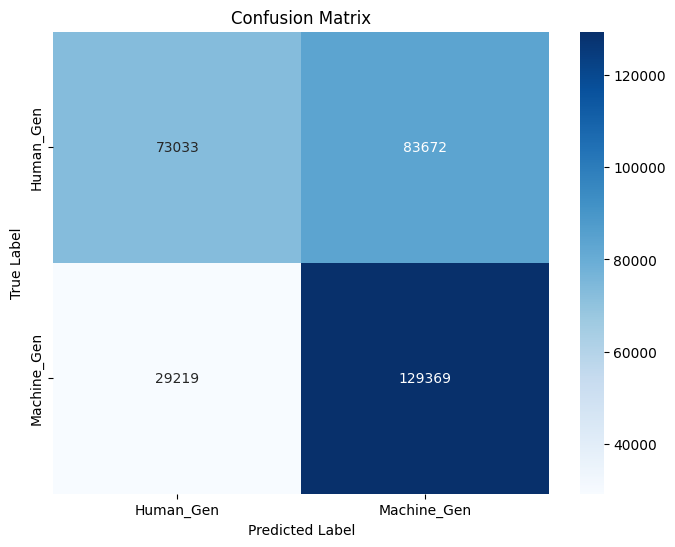

In [ ]:
# Plot the confusion matrix using Seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

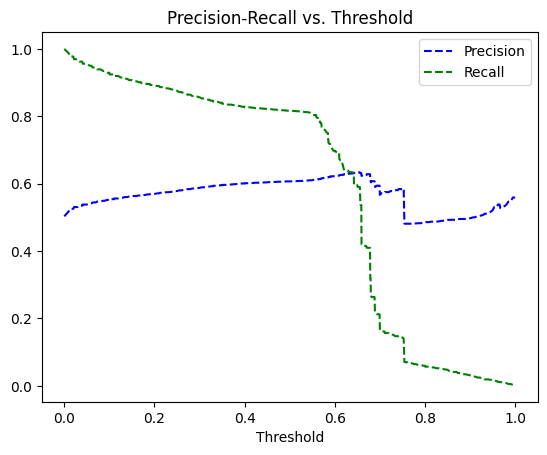

In [ ]:
# print(classification_report(y_test, y_pred))
y_prob = RF_classifier.predict_proba(X_test)[:,1]

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, roc_curve


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Precision-Recall vs. Threshold')
plt.show()

In [ ]:
# Set a new threshold (for example, 0.4)
threshold = 0.65
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate the model with the new threshold
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63    156705
           1       0.63      0.59      0.61    158588

    accuracy                           0.62    315293
   macro avg       0.62      0.62      0.62    315293
weighted avg       0.62      0.62      0.62    315293



ROC-AUC Score: 0.6572691803497122


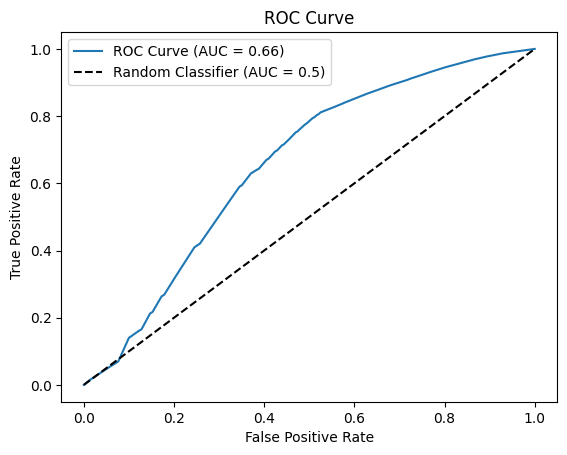

In [ ]:
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc_score}")

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)


# Feature Scaling - Generally recommended for Logistic Regression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the Logistic Regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.48      0.55    156705
           1       0.59      0.74      0.65    158588

    accuracy                           0.61    315293
   macro avg       0.62      0.61      0.60    315293
weighted avg       0.62      0.61      0.60    315293



In [ ]:
# Evaluation - Use the same metrics as in your Random Forest example
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

predictions = []

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, y_pred, average= 'macro')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall, )

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1 )

# Calculate Sensitivity (same as Recall)
sensitivity = recall
print("Sensitivity:", sensitivity)

# Calculate Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

Confusion Matrix:
[[ 74670  82035]
 [ 41543 117045]]
Accuracy: 0.6080534613835384
Precision: 0.6152282797383846
Recall: 0.7380444926476152
F1-score: 0.6544896384356442
Sensitivity: 0.7380444926476152
Specificity: 0.4765004307456686
False Positive Rate (FPR): 0.5234995692543314


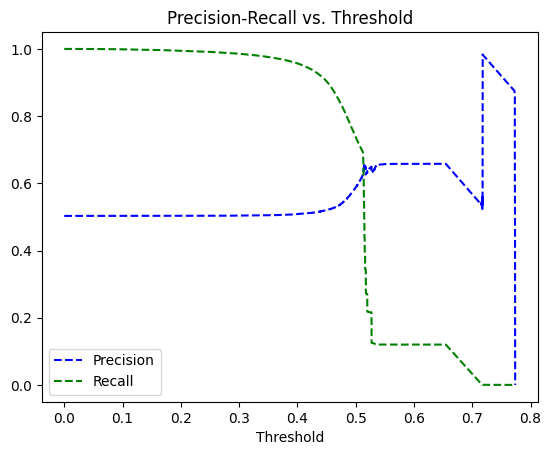

In [ ]:
# print(classification_report(y_test, y_pred))
y_prob = classifier.predict_proba(X_test)[:,1]

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, roc_curve


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Precision-Recall vs. Threshold')
plt.show()

In [ ]:
# Set a new threshold (for example, 0.4)
threshold = 0.65
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate the model with the new threshold
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.51      0.94      0.66    156705
           1       0.66      0.12      0.20    158588

    accuracy                           0.53    315293
   macro avg       0.59      0.53      0.43    315293
weighted avg       0.59      0.53      0.43    315293



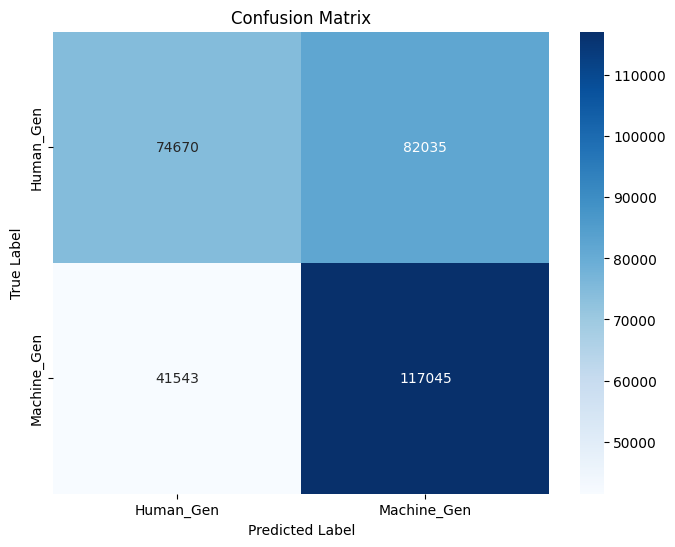

In [ ]:
# Plot the confusion matrix using Seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Instantiate the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the model on the training set
xgb_clf.fit(X_train, y_train)

# Predict probabilities and class labels
y_prob = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred = xgb_clf.predict(X_test)  # Predicted class labels

# Evaluate the performance
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_auc}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.66      0.63      0.65    156705
           1       0.65      0.68      0.67    158588

    accuracy                           0.66    315293
   macro avg       0.66      0.66      0.66    315293
weighted avg       0.66      0.66      0.66    315293

AUC-ROC Score: 0.700170251713579


In [ ]:
# Evaluation - Use the same metrics as in your Random Forest example
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predicting the Test set results
y_pred = xgb_clf.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, y_pred, average= 'macro')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall, )

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1 )

# Calculate Sensitivity (same as Recall)
sensitivity = recall
print("Sensitivity:", sensitivity)

# Calculate Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

Confusion Matrix:
[[ 98587  58118]
 [ 49961 108627]]
Accuracy: 0.6572109117550976
Precision: 0.6575634088661422
Recall: 0.6849635533583878
F1-score: 0.6677896186369043
Sensitivity: 0.6849635533583878
Specificity: 0.6291247886155515
False Positive Rate (FPR): 0.3708752113844485


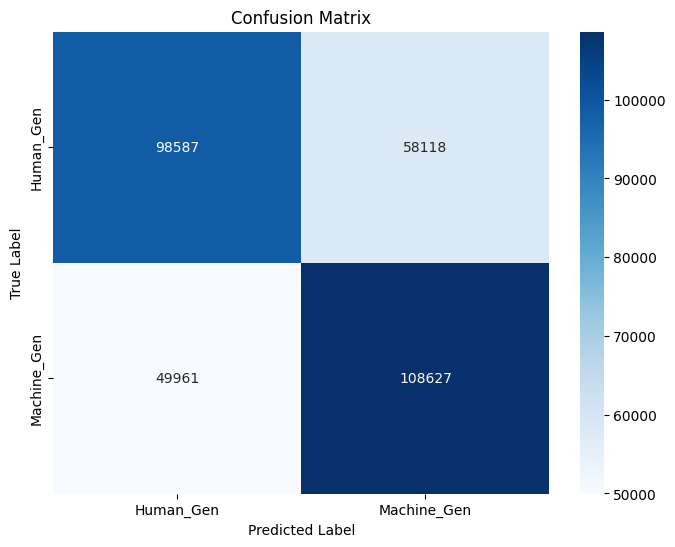

In [ ]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3]
}

# Instantiate XGBoost with RandomizedSearchCV for tuning
xgb_clf_tuned = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=True),
                                   param_distributions=param_grid, n_iter=20, cv=3, scoring='roc_auc', verbose=1, random_state=42)

# Fit the model
xgb_clf_tuned.fit(X_train, y_train)

# Get the best hyperparameters
print(f"Best Parameters: {xgb_clf_tuned.best_params_}")

# Make predictions using the best model
best_xgb_model = xgb_clf_tuned.best_estimator_
y_prob_tuned = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred_tuned = best_xgb_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_tuned))

# AUC-ROC Score
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)
print(f"AUC-ROC Score (Tuned Model): {roc_auc_tuned}")


In [ ]:
# Set a custom threshold for class prediction (e.g., threshold = 0.3)
threshold = 0.3
y_pred_adjusted = (y_prob_tuned >= threshold).astype(int)

# Evaluate the adjusted predictions
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.78      0.19      0.30    156705
           1       0.54      0.95      0.69    158588

    accuracy                           0.57    315293
   macro avg       0.66      0.57      0.49    315293
weighted avg       0.66      0.57      0.50    315293



In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation (using AUC-ROC as the scoring metric)
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='roc_auc')

print(f"Cross-Validated AUC-ROC Scores: {cv_scores}")
print(f"Mean AUC-ROC Score: {cv_scores.mean()}")


# Preparing data for prediction


In [ ]:
# Load TZA dataset and preprocess it

Data_tza = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Dataset_Tanzania.csv")


avg_segment_node_distance(Data_tza)
Data_tza['true_label'] = Data_tza.apply(assign_true_label, axis=1)
Data_tza['std_node_density'] = Data_tza['node_density'].std()
Data_tza['std_node_distance'] = Data_tza['avg_segment_node_distance'].std()
Data_tza['segment_length'] = round((Data_tza['road_length'])/1000,2)

# Reshape X to be a 2D array
X_to_predict = Data_tza.iloc[:, [-10,  -1]]
y_to_predict = Data_tza.iloc[:, -3]

print(X_to_predict.columns)  # Print the columns of the DataFrame X
# use one-hot encoding on the y variable


# Encoding the Dependent Variable (Classification)
le = LabelEncoder()
y_to_predict = le.fit_transform(y_to_predict)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(X_to_predict)  # Fit on the 2D array X
X = imputer.transform(X)    # Transform the data

Index(['node_density', 'std_node_distance'], dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [ ]:
# Select only the features used for training from Data_tza
# X_to_predict = Data_tza[['node_density', 'std_node_distance']]

# Impute missing values if necessary (using the same imputer used during training)
# X_to_predict = imputer.transform(X_to_predict)

# Make the prediction
xgb_predictions = xgb_clf.predict(X_to_predict)

print(classification_report(y_to_predict, xgb_predictions, zero_division="warn"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.43      1.00      0.61    571201
           1       0.00      0.00      0.00    745540

    accuracy                           0.43   1316741
   macro avg       0.22      0.50      0.30   1316741
weighted avg       0.19      0.43      0.26   1316741



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Select only the features used for training from Data_tza
# X_to_predict = Data_tza[['node_density', 'std_node_distance']]



# Feature Scaling - Generally recommended for Logistic Regression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tza = sc.fit_transform(X_to_predict)

In [ ]:

# Make the prediction
predictions = classifier.predict(X_to_predict)

print(predictions)
print(classification_report(y_to_predict, predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.47      0.02      0.04    571201
           1       0.57      0.98      0.72    745540

    accuracy                           0.56   1316741
   macro avg       0.52      0.50      0.38   1316741
weighted avg       0.53      0.56      0.43   1316741



In [ ]:
# Predictions for Randorm Forest
# Select only the features used for training from Data_tza
X_to_predict = Data_tza[['node_density', 'std_node_distance']]


# Make the prediction
RF_predictions = RF_classifier.predict(X_to_predict)

# Assuming y and X_to_predict are aligned now
print(RF_predictions)
print(classification_report(y_to_predict, RF_predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.44      0.77      0.56    571201
           1       0.59      0.25      0.35    745540

    accuracy                           0.48   1316741
   macro avg       0.51      0.51      0.46   1316741
weighted avg       0.52      0.48      0.44   1316741



# Predicting Ghana

In [ ]:

def avg_segment_node_distance1(gdf):
    """
    Calculate the average segment length per node for a GeoDataFrame of road segments.

    Parameters:

    - gdf: GeoDataFrame

        GeoDataFrame containing road segment geometries.

    Returns:

    - float

        Average segment length per node.
    """
    # Calculate the length of each road segment
    # gdf['segment_length'] = round((gdf['road_length'])/1000,2)

    # Calculate the number of nodes for each road segment
    gdf['num_nodes'] = gdf['num_nodes']
    # Calculate the average segment length per node
    gdf['avg_segment_node_distance'] = gdf['segment_length'] / (gdf['num_nodes'] - 1)

    # Calculate the overall average
    overall_average = gdf['avg_segment_node_distance'].mean()

    return overall_average

In [ ]:
# Load tiger dataset and preprocess it

Data_tiger = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Tiger_Alabama.csv")

# Data_tiger['segment_length'] = round((Data_tiger['road_length'])/1000,2)

avg_segment_node_distance1(Data_tiger)
Data_tiger['true_label'] = 1 #Data_tiger.apply(assign_true_label, axis=1)
Data_tiger['std_node_density'] = Data_tiger['node_density'].std()
Data_tiger['std_node_distance'] = Data_tiger['avg_segment_node_distance'].std()
Data_tiger['segment_length'] = round((Data_tiger['segment_length'])/1000,2)

# Reshape X to be a 2D array
X_to_predict_t = Data_tiger.iloc[:, [-5,  -1]]
y_to_predict_t = Data_tiger.iloc[:, -3]

print(X_to_predict.columns)  # Print the columns of the DataFrame X
# use one-hot encoding on the y variable


# Encoding the Dependent Variable (Classification)
le = LabelEncoder()
y_to_predict_t = le.fit_transform(y_to_predict_t)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(X_to_predict_t)  # Fit on the 2D array X
X = imputer.transform(X_to_predict_t)    # Transform the data

Index(['node_density', 'std_node_distance'], dtype='object')


In [ ]:
# Make the prediction with XGB for Tiger
xgb_predictions_t = xgb_clf.predict(X_to_predict_t)

print(classification_report(y_to_predict_t, xgb_predictions_t, zero_division="warn"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2681

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_to_predict_t, xgb_predictions_t)
print(cm)


[[2681]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# Load TomTom dataset and preprocess it

Data_tomtom = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/TomTom_Berlin.csv")

# Data_tiger['segment_length'] = round((Data_tiger['road_length'])/1000,2)

avg_segment_node_distance1(Data_tomtom)
Data_tomtom['true_label'] = 1 #Data_tiger.apply(assign_true_label, axis=1)
Data_tomtom['std_node_density'] = Data_tomtom['node_density'].std()
Data_tomtom['std_node_distance'] = Data_tomtom['avg_segment_node_distance'].std()
Data_tomtom['segment_length'] = round((Data_tomtom['segment_length'])/1000,2)

# Reshape X to be a 2D array
X_to_predict_T = Data_tomtom.iloc[:, [-5,  -1]]
y_to_predict_T = Data_tomtom.iloc[:, -3]

print(X_to_predict_T.columns)  # Print the columns of the DataFrame X
# use one-hot encoding on the y variable


# Encoding the Dependent Variable (Classification)
le = LabelEncoder()
y_to_predict_T = le.fit_transform(y_to_predict_T)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(X_to_predict_T)  # Fit on the 2D array X
X = imputer.transform(X_to_predict_T)    # Transform the data

Index(['node_density', 'std_node_distance'], dtype='object')


In [ ]:
# Make the prediction with XGB for TomTom
xgb_predictions_T = xgb_clf.predict(X_to_predict_t)

print(classification_report(y_to_predict_t, xgb_predictions_T, zero_division="warn"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2681

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681

